In [5]:
from importlib import reload
import pygsti
import qubic.job_manager_jpm as _jm
from pygsti.models import modelconstruction as _mc
from matplotlib import pyplot as plt
from qubic.state_disc import GMMManager
import chipcalibration.rabi_amp_sweep as _rabi
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import qubic.rpc_client as rc
import chipcalibration.repeated_xgates as _xgate

In [6]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname)

In [7]:
reload(_jm)
reload(_xgate)
reload(_rabi)

<module 'chipcalibration.rabi_amp_sweep' from '/home/jpmarceaux/chipcalibration/chipcalibration/rabi_amp_sweep.py'>

In [8]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner)

### first, run rabi and get the gmm

In [9]:
target_qubits = ['Q1']
#target_qubits = ['Q3']
target_twidth = 24e-9

In [10]:
num_partitions = 25
irabi = _rabi.RabiAmpSweeper(target_qubits, target_twidth, qchip, fpga_config, channel_config, num_partitions=num_partitions)

In [11]:
qchip.gates['Q1X90'].cfg_dict

[{'fcarrier': 'Q1.freq',
  'pcarrier': 0.0,
  'dest': 'Q1.qdrv',
  'twidth': 2.4e-08,
  't0': 0.0,
  'amp': 0.4745242933257867,
  'env': [{'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25}}]}]

In [12]:
# fit is A*sin(2*pi*x/drive_period + phi) + B, params are [A, B, drive_period, phi]
prior_fit_params = {
    'Q0' : [-0.5, 0.5, 0.5, 0], 
    'Q1' : [-0.5, 0.5, 0.8, 0], 
    'Q2' : [-0.5, 0.5, 0.8, 0], 
    'Q3' : [-0.5, 0.5, 0.8, 0], 
    'Q4' : [-0.5, 0.5, 0.8, 0], 
    'Q5' : [-0.5, 0.5, 0.8, 0], 
}

In [13]:
circs = irabi.circuits

In [14]:
irabi.run_and_fit(jm, 1000, prior_fit_params)

Taking data for qubit Q1 in batch 1 of 1
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
do

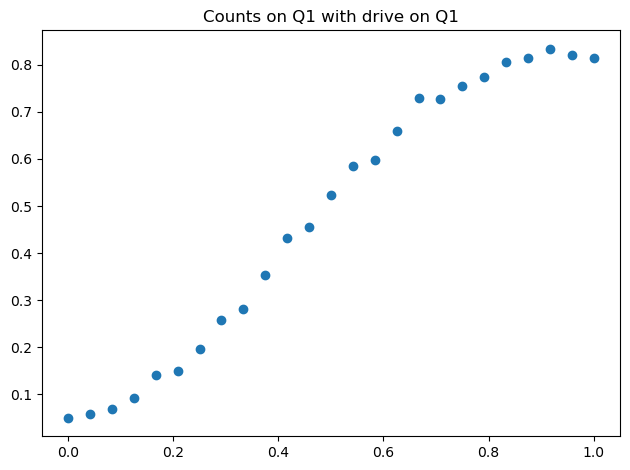

In [15]:
irabi.show_count_oscillations('Q1')

In [16]:
gmm = irabi.gmm_manager

In [17]:
jm = jm = _jm.JobManager(fpga_config, channel_config, runner, gmm)

## now run repeated X gate calibration

In [28]:
register = ['Q1']  # these correspond to the actual qubit id's on the qubic device
center_amp = qchip.gates['Q1X90'].cfg_dict[0]['amp']

In [29]:
xreps = _xgate.XGateRepetition(register, ['Q1'], center_amp, 0.1, 5, 5)

done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block
done z-resolving block
done scheduling
done resolving block
done z-resolving block
done resolving block

/home/jpmarceaux/chipcalibration/chipcalibration/repeated_xgates.py:142: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1

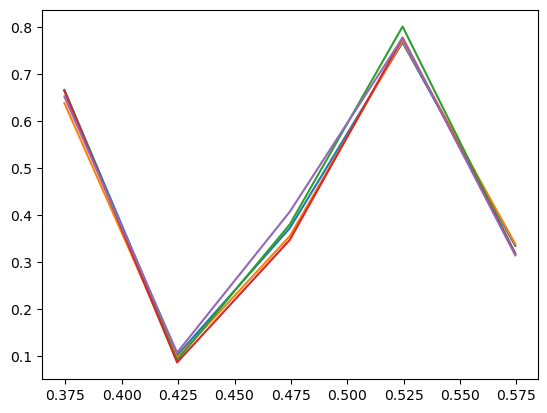

In [30]:
xreps.run_and_report(jm, 1000, qchip)